# **Eco-Risk Alpha: Measuring the Green Discount in Counterparty CVA**

## **Objective**

The project centers on a portfolio of interest-rate swaps (IRS). Your mission is to build statistical and
machine learning models that explain credit-default-swap (CDS) spreads using ESG and fundamental risk factor variables. You will then translate those spreads into CVA numbers to quantify a potential ”green
credit premium”.

## **Case Study Problem**

Banks quote and hedge CVA to cover expected losses from counterparty default. If greener companies genuinely default less or trade tighter in credit markets, a dealer can lower its CVA charges by selecting such
counterparties.
However the empirical evidence is mixed: some studies suggest a measurable ”ESG discount”, whereas others
argue that credit markets already price sustainability metrics.
Your task is to test this hypothesis by:
- Linking ESG scores to observed CDS spreads
- Converting both market and model-implied spreads into default intensities
- Computing Unilateral CVA for a benchmark swap exposure
- Comparing actual vs. ESG-implied CVA to derive a ”green-premium” measure

## **Case Study Core Tasks**

You will work through a structured sequence of tasks designed to simulate the workflow of a quant on a
trading desk. Each task builds on the previous one, combining financial insight with data science techniques.
1. **Data exploration and cleaning**: Visualize CDS vs. ESG, identify and handle outliers (if necessary),
missing values and check for duplicates
2. **Baseline linear model**: Regress CDS spread on ESG scores and some dummies (up to you to choose
which)
3. **Factor selection rationale**: Justify your variable choices to isolate the ESG effect
4. **CVA computation**: Convert actual and model-predicted spreads to hazard rates, then apply the unilateral CVA formula using the provided EE profile
5. **Machine learning model**: Train a model (ideally a model where you can explain the importance of the
variables in your results, e.g.: Random Forest or Gradient Boosting) to predict CDS spreads (you are
free to choose the features based on your own feature selection rationale) and compute CVA
6. **Machine learning comparison**: Compare CVA actual vs. CVA predicted (from both models), bucket firms by ESG
tertile, and interpret the economic significance of the green premium





# **Setup**

In [1]:
from pathlib import Path
import sys

# Add project root to sys.path for notebook
PROJECT_ROOT = Path().resolve().parent
sys.path.append(str(PROJECT_ROOT))

# Import dependencies
from src.imports import *

# Reproducibility
from src.constants import SEED
np.random.seed(SEED)

# Constants
from src.constants import LGD, RECOVERY


# **Upload Data**

In [2]:
from src.config import DATA_DIR

companies_df = pd.read_csv(DATA_DIR / "raw_companies_data.csv")
ee_df = pd.read_csv(DATA_DIR / "synthetic_irs_ee_profile.csv")
zeros_df = pd.read_csv(DATA_DIR / "zero_rates.csv")

# **Data Exploration and Cleaning**

## Show data

In [7]:
display(companies_df.head())

,Unnamed: 0,Company,Sector,Region,ESG_Score,E_Score,S_Score,G_Score,Carbon_Intensity,Market_Cap,Total_Assets,Debt_to_Equity,EBITDA_Margin,Leverage_Ratio,CDS_Spread_5Y
0,1,Company_1,technology,North America,52.4724,88.1751,31.8858,84.4960,NaN,30150.4403,12232.9808,1.5591,8.6093,1.5766,34.0068
1,2,Company_2,technology,North America,52.4724,88.1751,31.8858,84.4960,NaN,30150.4403,12232.9808,1.5591,8.6093,1.5766,34.0068
2,3,Company_3,Consumer Goods,north america,87.0429,76.5080,68.1846,44.3737,71.0350,39124.6751,107208.2171,2.5838,36.5894,1.1610,38.1718
3,4,Company_4,FINANCE,Europe,73.9196,86.3699,48.8614,38.6937,90.4072,85262.5305,109045.7541,2.0102,22.6838,0.9060,61.7321
4,5,Company_5,Technology,ASIA,65.9195,83.6896,60.5142,59.3672,274.6385,32375.2785,128211.1205,0.5725,33.9260,1.8221,29.9490


In [8]:
display(companies_df.describe())

,Unnamed: 0,ESG_Score,E_Score,S_Score,G_Score,Carbon_Intensity,Market_Cap,Total_Assets,Debt_to_Equity,EBITDA_Margin,Leverage_Ratio,CDS_Spread_5Y
count,60.000000,54.000000,60.000000,60.000000,60.000000,52.000000,53.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,30.500000,57.914019,58.802118,56.639408,62.468137,216.242906,64191.576042,86954.479015,1.631280,21.073603,1.123024,34.238417
std,17.464249,16.748522,18.604903,18.412452,17.356465,188.244835,91289.452092,53289.909089,0.863179,11.382240,0.627700,18.291079
min,1.000000,32.063300,30.331300,30.417100,30.995300,51.265400,4019.524700,4849.910700,0.152800,5.379300,0.121600,4.720900
25%,15.750000,43.436925,41.881925,42.793425,44.520250,103.119900,22366.281700,51050.735900,0.917650,8.574300,0.575900,18.919300
50%,30.500000,56.886650,56.992700,53.220400,66.695950,197.916650,51622.897500,85080.812400,1.768900,18.622100,1.152300,29.887100
75%,45.250000,72.126800,76.262550,72.969100,76.792500,262.542525,79783.474300,126834.403100,2.319900,31.510550,1.791500,48.224450
max,60.000000,88.194600,89.213200,88.306900,89.139000,1038.923300,523146.355800,195218.711700,2.972500,39.532400,1.986600,72.005700


## Drop uninformative columns

In [9]:
companies_df_clean = companies_df.copy()
companies_df_clean.drop(columns=['Unnamed: 0', 'Company'], inplace=True)

## Uniform Sector and Region names

In [10]:
# Sector
print('Unique sectors before cleaning:')
print(companies_df_clean['Sector'].unique())
companies_df_clean['Sector'] = companies_df_clean['Sector'].str.title()
companies_df_clean['Sector'] = companies_df_clean['Sector'].replace('Tech', 'Technology')
print('Unique sectors after cleaning:')
print(companies_df_clean['Sector'].unique())

print('\n')

# Region
print('Unique regions before cleaning:')
print(companies_df_clean['Region'].unique())
companies_df_clean['Region'] = companies_df_clean['Region'].str.title()
print('Unique regions after cleaning:')
print(companies_df_clean['Region'].unique())

Unique sectors before cleaning:
['technology' 'Consumer Goods' 'FINANCE' 'Technology' 'Utilities'
 'Finance' 'Healthcare' 'Industrials' 'Energy' 'Tech']
Unique sectors after cleaning:
['Technology' 'Consumer Goods' 'Finance' 'Utilities' 'Healthcare'
 'Industrials' 'Energy']


Unique regions before cleaning:
['North America' 'north america' 'Europe' 'ASIA' 'South America' 'Asia']
Unique regions after cleaning:
['North America' 'Europe' 'Asia' 'South America']


## Check and Drop duplicate entries

In [11]:
# Check duplicate rows
dup_rows = companies_df_clean.duplicated().sum()
print(f"Duplicate rows: {dup_rows}")
if dup_rows > 0:
    display(companies_df_clean[companies_df_clean.duplicated(keep=False)])
    shape_before = companies_df_clean.shape
    # Remove duplicate rows, keeping the first occurrence
    companies_df_clean = companies_df_clean.drop_duplicates(keep='first').reset_index(drop=True)
    print(f"Shape before: {shape_before}")
    print(f"Shape after: {companies_df_clean.shape}")

Duplicate rows: 9


,Sector,Region,ESG_Score,E_Score,S_Score,G_Score,Carbon_Intensity,Market_Cap,Total_Assets,Debt_to_Equity,EBITDA_Margin,Leverage_Ratio,CDS_Spread_5Y
0,Technology,North America,52.4724,88.1751,31.8858,84.4960,NaN,30150.4403,12232.9808,1.5591,8.6093,1.5766,34.0068
1,Technology,North America,52.4724,88.1751,31.8858,84.4960,NaN,30150.4403,12232.9808,1.5591,8.6093,1.5766,34.0068
10,Utilities,Europe,72.4844,49.5198,34.6188,73.6930,90.2020,10620.4729,55624.7857,1.7689,8.1950,0.3258,29.8871
11,Utilities,Europe,72.4844,49.5198,34.6188,73.6930,90.2020,10620.4729,55624.7857,1.7689,8.1950,0.3258,29.8871
12,Utilities,Europe,72.4844,49.5198,34.6188,73.6930,90.2020,10620.4729,55624.7857,1.7689,8.1950,0.3258,29.8871
13,Utilities,Europe,72.4844,49.5198,34.6188,73.6930,90.2020,10620.4729,55624.7857,1.7689,8.1950,0.3258,29.8871
24,Consumer Goods,North America,47.4737,89.2132,62.3605,65.4536,262.3059,30065.5926,51548.0938,0.3011,31.3331,1.9301,54.0745
25,Consumer Goods,North America,47.4737,89.2132,62.3605,65.4536,262.3059,30065.5926,51548.0938,0.3011,31.3331,1.9301,54.0745
35,Consumer Goods,South America,32.7870,36.9521,60.6448,38.2513,1038.9233,79783.4743,51050.7359,0.9174,9.0973,1.0939,13.4173
36,Consumer Goods,South America,32.7870,36.9521,60.6448,38.2513,1038.9233,79783.4743,51050.7359,0.9174,9.0973,1.0939,13.4173


Shape before: (60, 13)
Shape after: (51, 13)


## Compute missing ESG from E,S,G pillars

In [12]:
# Compute ESG from pillars
mask = companies_df_clean['ESG_Score'].isnull()
display(companies_df_clean[mask])
companies_df_clean.loc[mask, 'ESG_Score'] = (
    0.5 * companies_df_clean.loc[mask, 'E_Score'] +
    0.3 * companies_df_clean.loc[mask, 'S_Score'] +
    0.2 * companies_df_clean.loc[mask, 'G_Score']
)

# Remove E,S,G pillars from database
shape_before = companies_df_clean.shape
companies_df_clean = companies_df_clean.drop(columns=['E_Score', 'S_Score', 'G_Score'])
print(f"Shape before: {shape_before}")
print(f"Shape after: {companies_df_clean.shape}")


,Sector,Region,ESG_Score,E_Score,S_Score,G_Score,Carbon_Intensity,Market_Cap,Total_Assets,Debt_to_Equity,EBITDA_Margin,Leverage_Ratio,CDS_Spread_5Y
10,Technology,Europe,NaN,53.3206,47.3851,52.0670,187.1834,61885.7154,88916.3413,1.2257,16.1760,0.3233,38.4872
15,Technology,Asia,NaN,62.5618,82.2876,80.1181,NaN,NaN,139802.8928,1.2197,20.6956,0.8123,72.0057
16,Finance,Europe,NaN,55.5832,36.6031,82.1889,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,Technology,South America,NaN,76.2762,79.0809,71.4563,293.2526,80031.2227,111762.1024,2.5501,20.4536,0.2402,38.5885
31,Energy,South America,NaN,81.7862,55.0447,50.4640,248.7028,89110.5288,72482.5904,0.4427,10.0047,1.2959,18.6566
32,Healthcare,Asia,NaN,67.3979,43.3265,36.8084,NaN,34461.5205,152053.5299,2.1205,31.6529,1.4219,4.7209


Shape before: (51, 13)
Shape after: (51, 10)


## Check and Replace missing values

In [13]:
# Check missing values
missing_summary = companies_df_clean.isnull().sum().sort_values(ascending=False)
print("\nMissing values per column:")
display(missing_summary)



Missing values per column:


Market_Cap          6
Carbon_Intensity    6
Leverage_Ratio      1
EBITDA_Margin       1
Total_Assets        1
Debt_to_Equity      1
CDS_Spread_5Y       1
Sector              0
Region              0
ESG_Score           0
dtype: int64

In [14]:
# Delete column Market Cap (too many NaNs)
print(f"\nNumber of NaNs in Market_Cap: {companies_df_clean['Market_Cap'].isnull().sum()}")
companies_df_clean = companies_df_clean.drop(columns=['Market_Cap'])

# Delete row 16 (too many NaNs)
print(f"\nRow 16 data before deletion:")
display(companies_df_clean.iloc[16])
companies_df_clean = companies_df_clean.drop(index=16).reset_index(drop=True)

# Flag missing Carbon Intensity
companies_df_clean['CI_NaN'] = companies_df_clean['Carbon_Intensity'].isnull()

# Sector-wise median imputation for Carbon Intensity
companies_df_clean['Carbon_Intensity'] = companies_df_clean.groupby('Sector')['Carbon_Intensity'].transform(lambda x: x.fillna(x.median()))

# Remove flag from df
companies_df_clean = companies_df_clean.drop(columns=['CI_NaN'])


Number of NaNs in Market_Cap: 6

Row 16 data before deletion:


Sector               Finance
Region                Europe
ESG_Score           55.21031
Carbon_Intensity         NaN
Total_Assets             NaN
Debt_to_Equity           NaN
EBITDA_Margin            NaN
Leverage_Ratio           NaN
CDS_Spread_5Y            NaN
Name: 16, dtype: object

## Visualize data

In [15]:
# Basic summary of CDS and ESG
cols = ['CDS_Spread_5Y', 'ESG_Score']
summary_table = companies_df[cols].describe().T 
summary_table = summary_table[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
summary_table

,count,mean,std,min,25%,50%,75%,max
CDS_Spread_5Y,59.0,34.238417,18.291079,4.7209,18.919300,29.88710,48.22445,72.0057
ESG_Score,54.0,57.914019,16.748522,32.0633,43.436925,56.88665,72.12680,88.1946


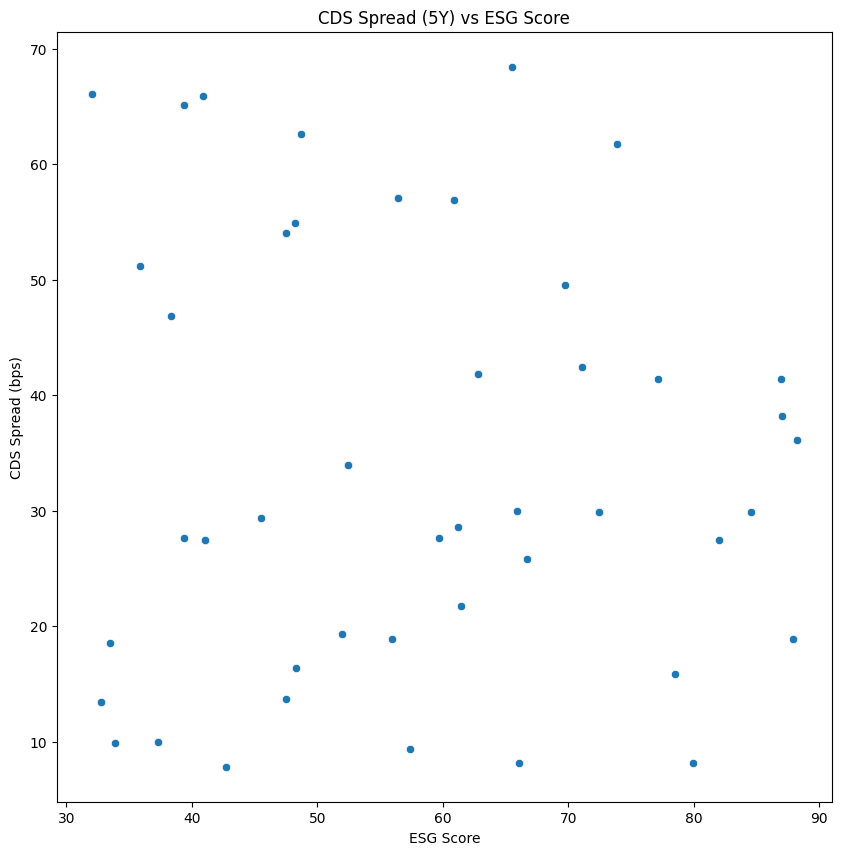

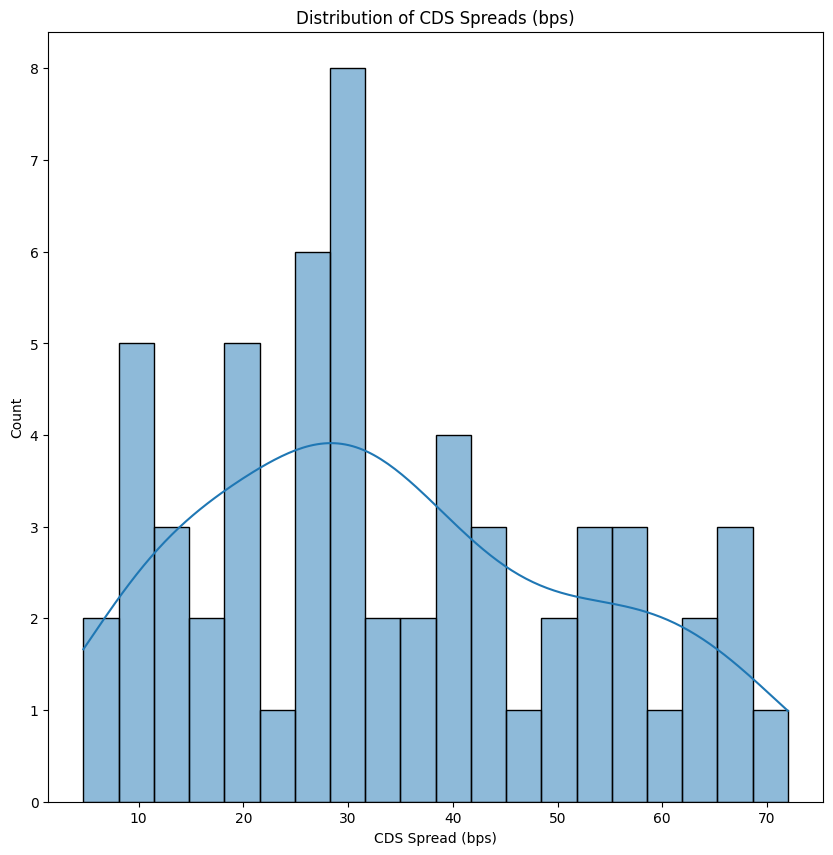

In [16]:
# Scatter plot CDS vs ESG
plt.figure(figsize=(10,10))
sns.scatterplot(data=companies_df, x='ESG_Score', y='CDS_Spread_5Y')
plt.title("CDS Spread (5Y) vs ESG Score")
plt.xlabel("ESG Score")
plt.ylabel("CDS Spread (bps)")
plt.show()

# Histogram of CDS spreads
plt.figure(figsize=(10,10))
sns.histplot(companies_df['CDS_Spread_5Y'], bins=20, kde=True)
plt.title("Distribution of CDS Spreads (bps)")
plt.xlabel("CDS Spread (bps)")
plt.show()

## Search for Outliers

In [17]:
# Domain specific violations
print('Companies with too negative Debt to Equity:', sum(companies_df_clean['Debt_to_Equity'] < -1))
print('Companies with negative Total Assets:', sum(companies_df_clean['Total_Assets'] < 0))
print('Companies with too high CDS spread', sum(companies_df_clean['CDS_Spread_5Y'] > 5000))

Companies with too negative Debt to Equity: 0
Companies with negative Total Assets: 0
Companies with too high CDS spread 0


Outliers detected: 3 (6.00% of data)


,Sector,Region,ESG_Score,Carbon_Intensity,Total_Assets,Debt_to_Equity,EBITDA_Margin,Leverage_Ratio,CDS_Spread_5Y,Outlier,Outlier_Type
5,Technology,South America,39.3597,52.2993,195218.7117,1.9630,36.3433,1.0360,65.1008,True,"Low ESG, Low Carbon Intensity"
29,Consumer Goods,South America,32.7870,1038.9233,51050.7359,0.9174,9.0973,1.0939,13.4173,True,High Carbon Intensity
34,Healthcare,Europe,87.9379,494.0537,11108.5231,2.2317,7.9437,1.2102,18.9321,True,High Carbon Intensity



Summary statistics for non-outliers:


,count,mean,std,min,25%,50%,75%,max
ESG_Score,47.0,59.101588,16.076769,32.0633,47.50120,59.7106,71.52240,88.1946
Carbon_Intensity,47.0,186.874269,73.619919,51.2654,125.77150,201.6073,239.56390,293.2526
Total_Assets,47.0,92931.178698,52597.970726,4849.9107,53586.43975,95886.4182,130465.10055,192604.3861
Debt_to_Equity,47.0,1.617949,0.913452,0.1528,0.79285,1.7689,2.43495,2.9725
EBITDA_Margin,47.0,23.029677,10.961832,5.3793,15.71920,22.6838,32.67095,39.5324
Leverage_Ratio,47.0,1.098374,0.628772,0.1216,0.57590,1.1523,1.77090,1.9866
CDS_Spread_5Y,47.0,34.150670,18.809481,4.7209,18.78155,29.8871,48.22445,72.0057



Summary statistics for outliers:


,count,mean,std,min,25%,50%,75%,max
ESG_Score,3.0,53.361533,30.123810,32.7870,36.07335,39.3597,63.64880,87.9379
Carbon_Intensity,3.0,528.425433,494.209259,52.2993,273.17650,494.0537,766.48850,1038.9233
Total_Assets,3.0,85792.656900,96847.257022,11108.5231,31079.62950,51050.7359,123134.72380,195218.7117
Debt_to_Equity,3.0,1.704033,0.694366,0.9174,1.44020,1.9630,2.09735,2.2317
EBITDA_Margin,3.0,17.794767,16.073853,7.9437,8.52050,9.0973,22.72030,36.3433
Leverage_Ratio,3.0,1.113367,0.088717,1.0360,1.06495,1.0939,1.15205,1.2102
CDS_Spread_5Y,3.0,32.483400,28.381761,13.4173,16.17470,18.9321,42.01645,65.1008


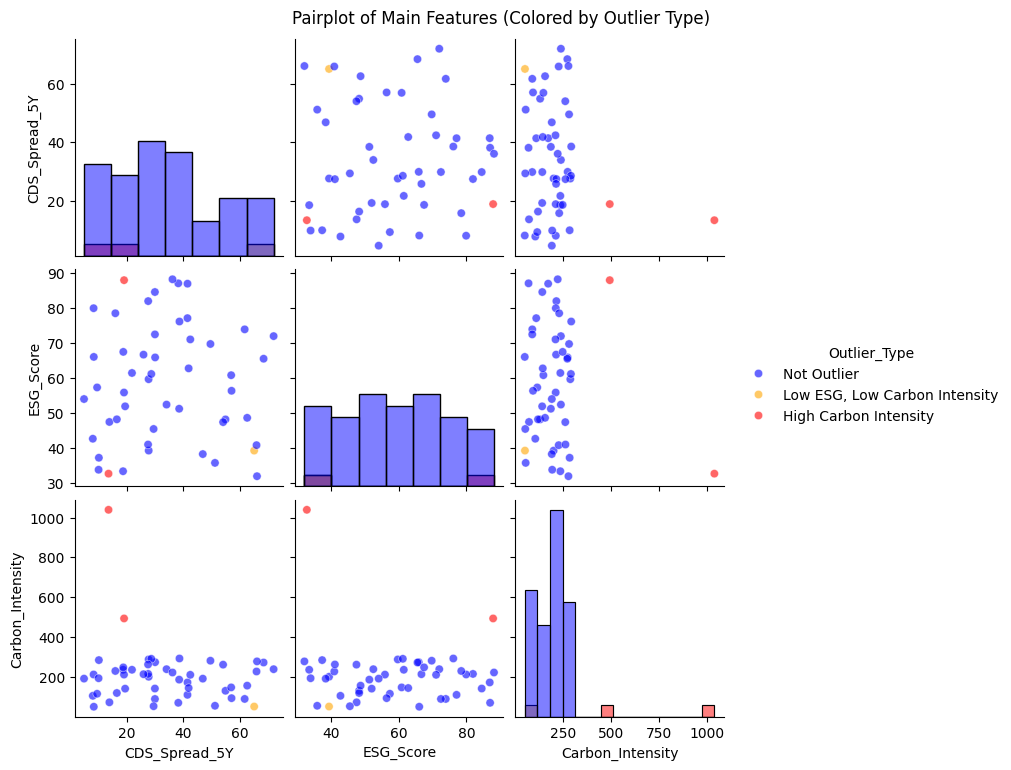

In [18]:
# Select only numeric columns for outlier detection
X_num = companies_df_clean[companies_df_clean.columns.drop(['Sector','Region'])]

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=SEED)
outlier_pred = iso_forest.fit_predict(X_num)

# Add outlier flag to DataFrame
companies_df_clean['Outlier'] = (outlier_pred == -1)

# Categorize outliers based on characteristics
companies_df_clean['Outlier_Type'] = 'Not Outlier'
outlier_indices = companies_df_clean[companies_df_clean['Outlier']].index.tolist()

# Categorize outliers
if 29 in outlier_indices:
    companies_df_clean.loc[29, 'Outlier_Type'] = 'High Carbon Intensity'
if 34 in outlier_indices:
    companies_df_clean.loc[34, 'Outlier_Type'] = 'High Carbon Intensity'
if 5 in outlier_indices:
     companies_df_clean.loc[5, 'Outlier_Type'] = 'Low ESG, Low Carbon Intensity'

# Compare summary statistics and visualize outliers vs non-outliers
n_outliers = companies_df_clean['Outlier'].sum()
n_total = len(companies_df_clean)
print(f"Outliers detected: {n_outliers} ({n_outliers/n_total:.2%} of data)")
display(companies_df_clean[companies_df_clean['Outlier']])

print("\nSummary statistics for non-outliers:")
display(companies_df_clean[~companies_df_clean['Outlier']].describe().T)

print("\nSummary statistics for outliers:")
display(companies_df_clean[companies_df_clean['Outlier']].describe().T)

main_features = companies_df_clean.columns.drop(['Outlier','Outlier_Type', 'Sector','Region'])

sns.pairplot(companies_df_clean, vars=['CDS_Spread_5Y', 'ESG_Score', 'Carbon_Intensity'], hue='Outlier_Type', palette={'Not Outlier': "blue", 'High Carbon Intensity': "red", 'Low ESG, Low Carbon Intensity': "orange"}, plot_kws={'alpha':0.6}, diag_kind='hist')
plt.suptitle("Pairplot of Main Features (Colored by Outlier Type)", y=1.02)
plt.show()

companies_df_clean = companies_df_clean.drop(['Outlier', 'Outlier_Type'], axis=1)

# **Baseline Linear Models**

## Utilities

In [15]:
from src.utils import evaluate_model

## Trivial OLS

Trivial model (ESG only):
Train RMSE: 18.92, R²: 0.00
CV RMSE: 19.68


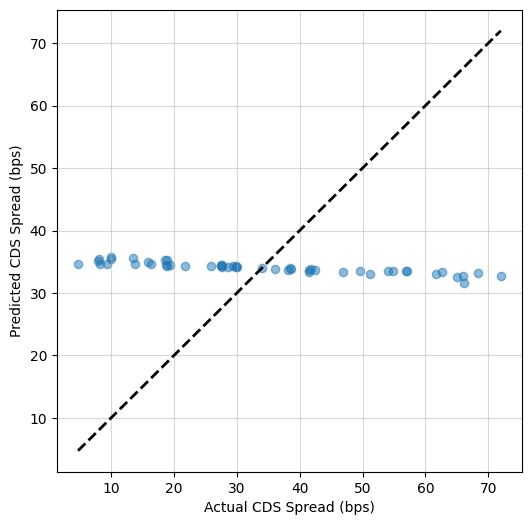

In [16]:
# Regression with only ESG
X = companies_df_clean[['ESG_Score']].values
y = companies_df_clean['CDS_Spread_5Y'].values
cv = LeaveOneOut()

ols = make_pipeline(StandardScaler(), LinearRegression())
print('Trivial model (ESG only):')
ols_results = evaluate_model(ols, X, y, cv=cv)

## Full OLS

Full model:
Train RMSE: 16.88, R²: 0.20
CV RMSE: 24.75


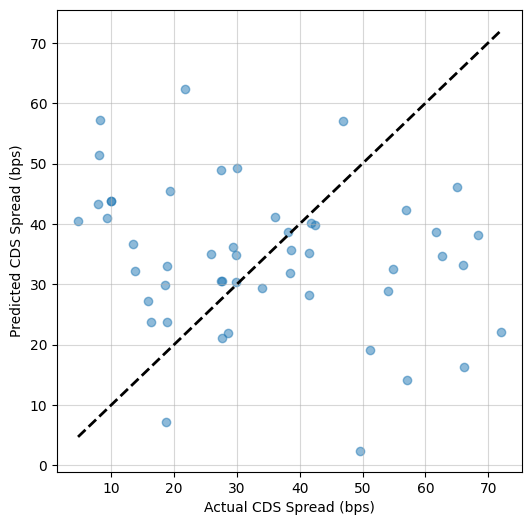

In [17]:
# Full regression
X = companies_df_clean.drop(columns=['CDS_Spread_5Y'])
X = pd.get_dummies(X, columns=['Sector', 'Region'], drop_first=True).values
y = companies_df_clean['CDS_Spread_5Y'].values
cv = LeaveOneOut()

ols = make_pipeline(StandardScaler(), LinearRegression())
print('Full model:')
ols_results = evaluate_model(ols, X, y, cv=cv)


## Lasso

Lasso Regression with Hyperparameter Tuning:
Best alpha: 11.1112
Train RMSE: 18.92, R²: 0.00
CV RMSE: 19.30


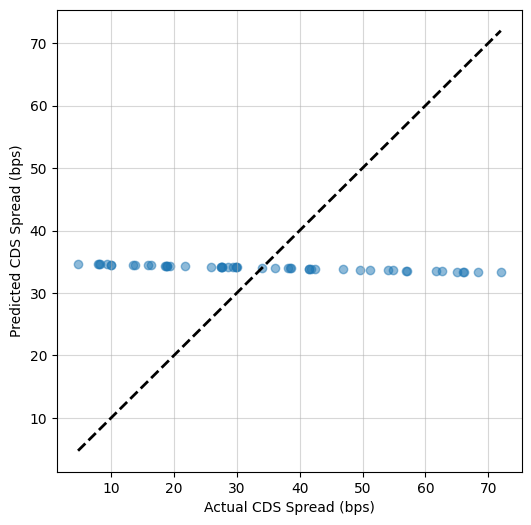

In [18]:
from sklearn.model_selection import GridSearchCV

X = companies_df_clean.drop(columns=['CDS_Spread_5Y'])
X = pd.get_dummies(X, columns=['Sector', 'Region'], drop_first=True).values
y = companies_df_clean['CDS_Spread_5Y'].values
cv = LeaveOneOut()

lasso_pipeline = make_pipeline(StandardScaler(), Lasso())

param_grid = {'lasso__alpha': np.linspace(1e-4, 100, 10)}

grid_search = GridSearchCV(
    lasso_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_mean_squared_error',
)

grid_search.fit(X, y)

print('Lasso Regression with Hyperparameter Tuning:')
print("Best alpha:", grid_search.best_params_['lasso__alpha'])
grid_search_results = evaluate_model(grid_search.best_estimator_, X, y, cv=cv)

## Feature Selection with sequential selection

In [19]:
X = companies_df_clean.drop(columns=['CDS_Spread_5Y'])
X = pd.get_dummies(X, columns=['Sector', 'Region'], drop_first=True)
y = companies_df_clean['CDS_Spread_5Y'].values

estimator = make_pipeline(StandardScaler(), LinearRegression())
cv = LeaveOneOut()

# Forward stepwise selection
sfs_forward = SFS(
    estimator,
    k_features="best",
    forward=True,
    floating=False,
    scoring='neg_mean_squared_error',
    cv=cv,
)

sfs_forward = sfs_forward.fit(X, y)

print("Forward-selected features:", sfs_forward.k_feature_names_)

# Backward stepwise selection
sfs_backward = SFS(
    estimator,
    k_features="best",
    forward=False,
    floating=False,
    scoring='neg_mean_squared_error',
    cv=cv,
)

sfs_backward = sfs_backward.fit(X, y)

print("Backward-selected features:", sfs_backward.k_feature_names_)


Forward-selected features: ('Carbon_Intensity', 'Leverage_Ratio', 'Sector_Energy')
Backward-selected features: ('Carbon_Intensity', 'Leverage_Ratio', 'Sector_Energy')


Forward Stepwise Selection:
Train RMSE: 17.87, R²: 0.11
CV RMSE: 18.74


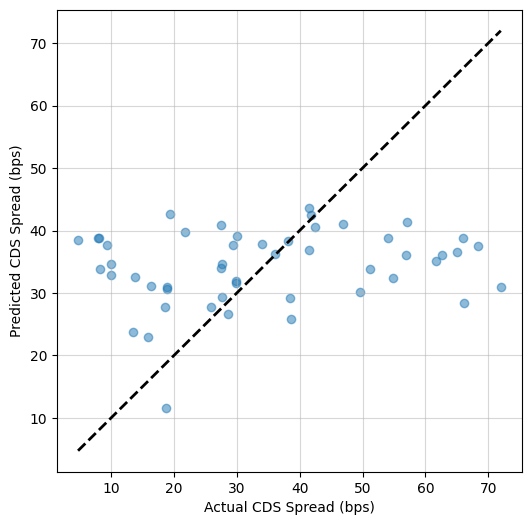

Backward Stepwise Selection:
Train RMSE: 17.87, R²: 0.11
CV RMSE: 18.74


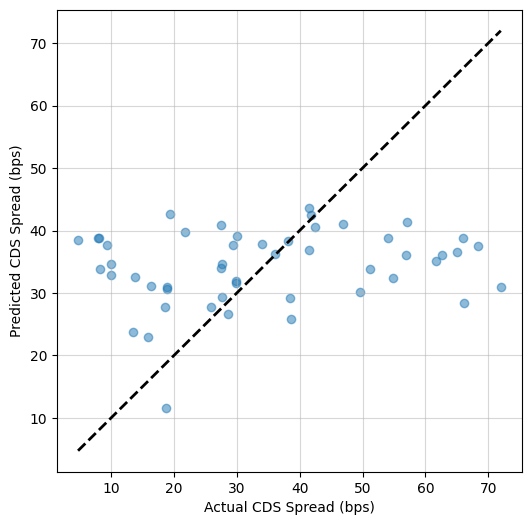

In [20]:
X = companies_df_clean.drop(columns=['CDS_Spread_5Y'])
X = pd.get_dummies(X, columns=['Sector', 'Region'], drop_first=True)
X_forward = X[list(sfs_forward.k_feature_names_)]
X_backward = X[list(sfs_backward.k_feature_names_)]
y = companies_df_clean['CDS_Spread_5Y'].values
cv = LeaveOneOut()

ols_forward = make_pipeline(StandardScaler(), LinearRegression())
print('Forward Stepwise Selection:')
ols_results_forward = evaluate_model(ols_forward, X_forward, y, cv=cv)

ols_backward = make_pipeline(StandardScaler(), LinearRegression())
print('Backward Stepwise Selection:')
ols_results_backward = evaluate_model(ols_backward, X_backward, y, cv=cv)

## Feature Selection with correlation

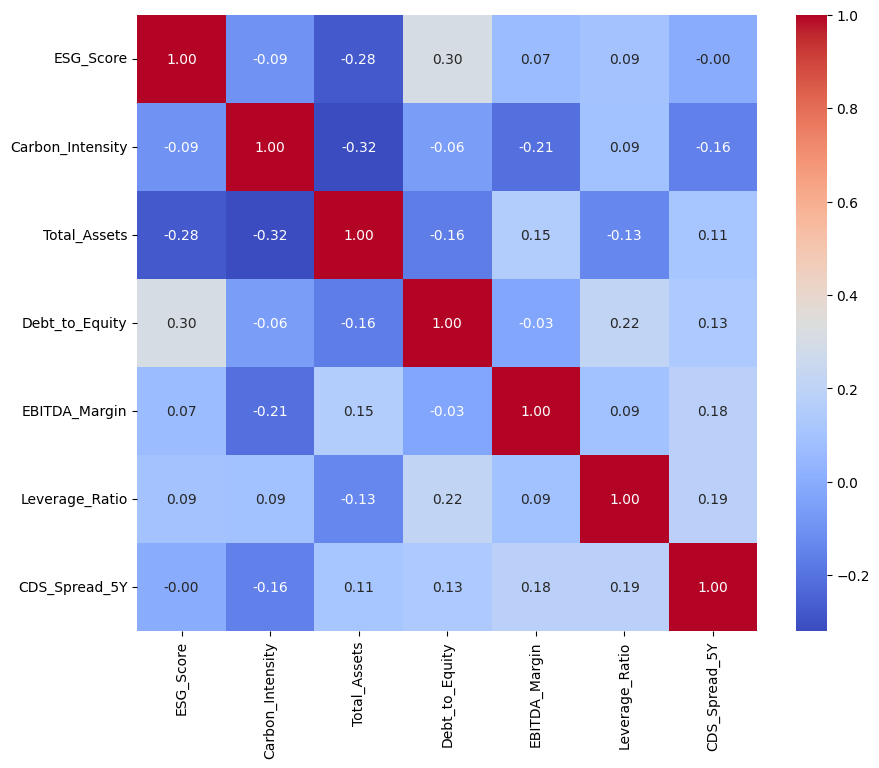

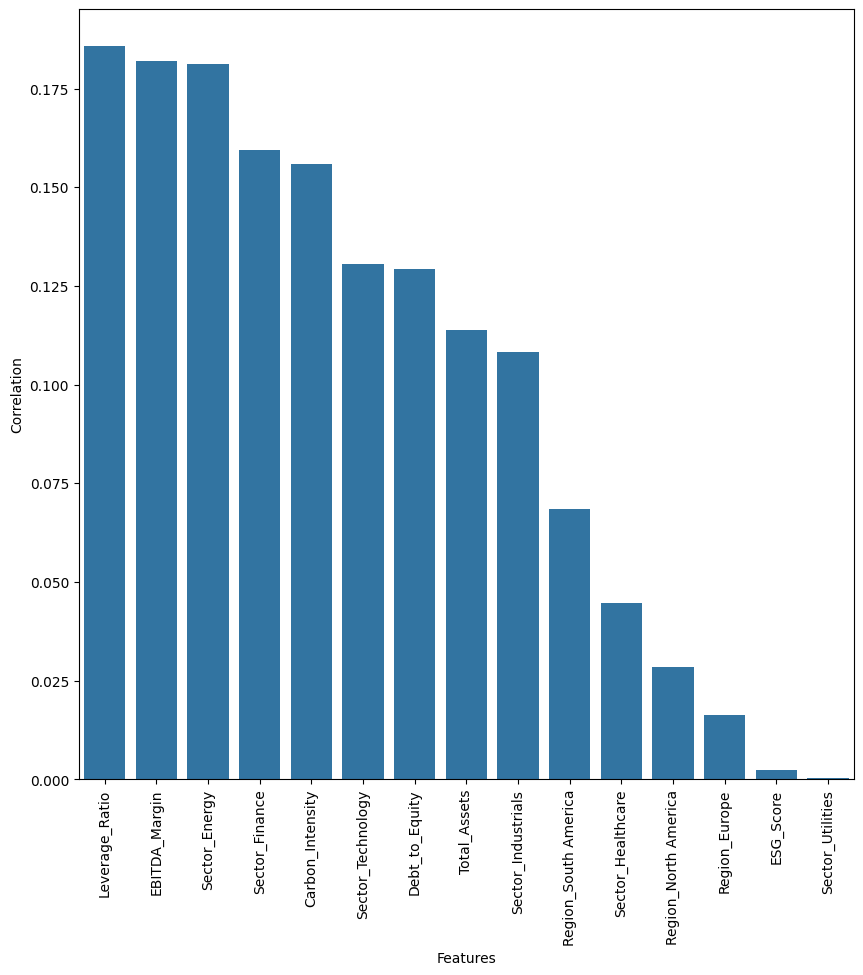

In [21]:
# Top N correlated features + ESG
N = 3
X = companies_df_clean

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(X.drop(columns=['Sector','Region']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

X = pd.get_dummies(X, columns=['Sector', 'Region'], drop_first=True)
corr = X.corr()

corr = np.abs(corr['CDS_Spread_5Y']).sort_values(ascending=False)[1:]

# Plot correlation
plt.figure(figsize=(10, 10))
sns.barplot(x=corr.index, y=corr.values)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.show()

features = [corr.index[i] for i in range(N)]
if 'ESG_Score' not in features:
    features.append('ESG_Score')
X = X[features].values
y = companies_df_clean['CDS_Spread_5Y'].values
cv = LeaveOneOut()

Top 3 Correlated Features + ESG:
Train RMSE: 17.92, R²: 0.10
CV RMSE: 19.39


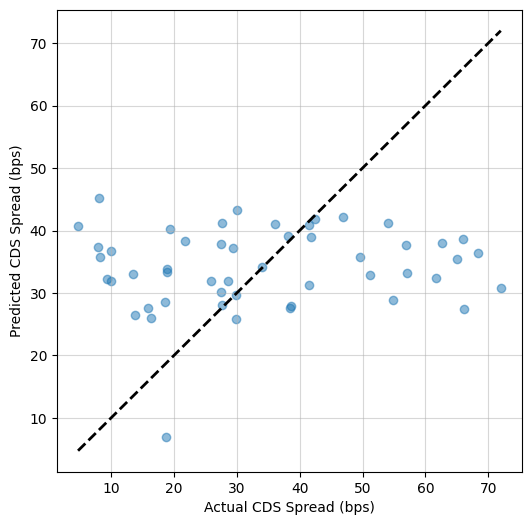

In [22]:
ols = make_pipeline(StandardScaler(), LinearRegression())
print(f'Top {N} Correlated Features + ESG:')
ols_results = evaluate_model(ols, X, y, cv=cv)

# **Machine Learning Models**

## Utilities

In [16]:
from src.utils import evaluate_model

## Random Forest

Random Forest Regression:
Train RMSE: 7.52, R²: 0.84
CV RMSE: 20.44


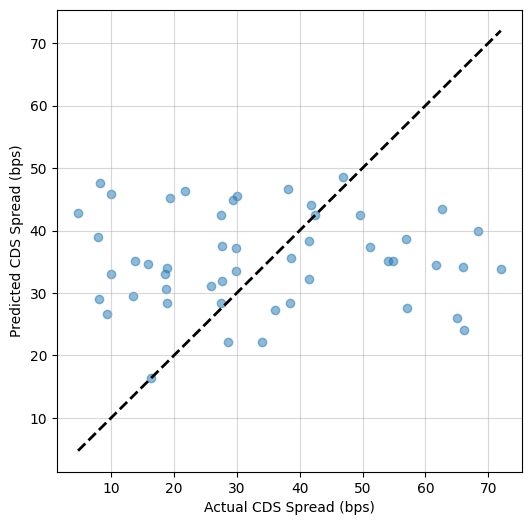

In [17]:
# Random Forest
X = companies_df_clean.drop(columns=['CDS_Spread_5Y'])
X = pd.get_dummies(X, columns=['Sector', 'Region'], drop_first=True).values
y = companies_df_clean['CDS_Spread_5Y'].values
cv = LeaveOneOut()

rf = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=SEED))
print('Random Forest Regression:')
rf_results = evaluate_model(rf, X, y, cv=cv)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:
  randomforestregressor__max_depth: 5
  randomforestregressor__min_samples_leaf: 1
  randomforestregressor__min_samples_split: 3
  randomforestregressor__n_estimators: 152

Evaluating best model:
Train RMSE: 9.01, R²: 0.77
CV RMSE: 19.68


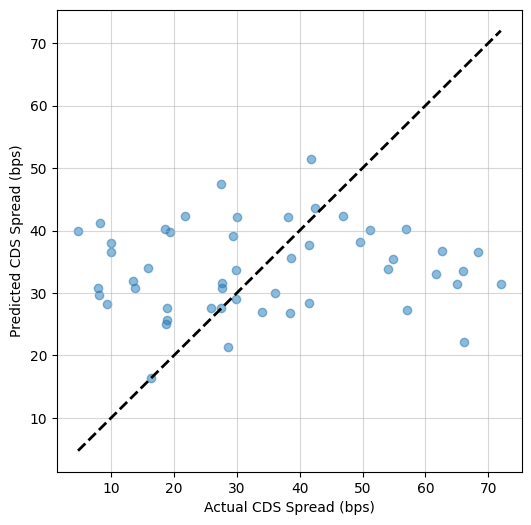

In [18]:
# Features and target
X = companies_df_clean.drop(columns=['CDS_Spread_5Y'])
X = pd.get_dummies(X, columns=['Sector', 'Region'], drop_first=True).values
y = companies_df_clean['CDS_Spread_5Y'].values
cv = 5

rf = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=SEED))

param_dist = {
    'randomforestregressor__n_estimators': randint(100, 500),
    'randomforestregressor__max_depth': [None, 5, 10, 20],
    'randomforestregressor__min_samples_split': randint(2, 10),
    'randomforestregressor__min_samples_leaf': randint(1, 5)
}

rand_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=SEED,
    verbose=1
)

rand_search.fit(X, y)

print("Best parameters found:")
for param, value in rand_search.best_params_.items():
    print(f"  {param}: {value}")

# Evaluate the best model
print("\nEvaluating best model:")
evaluate_model(rand_search.best_estimator_, X, y, cv=cv)

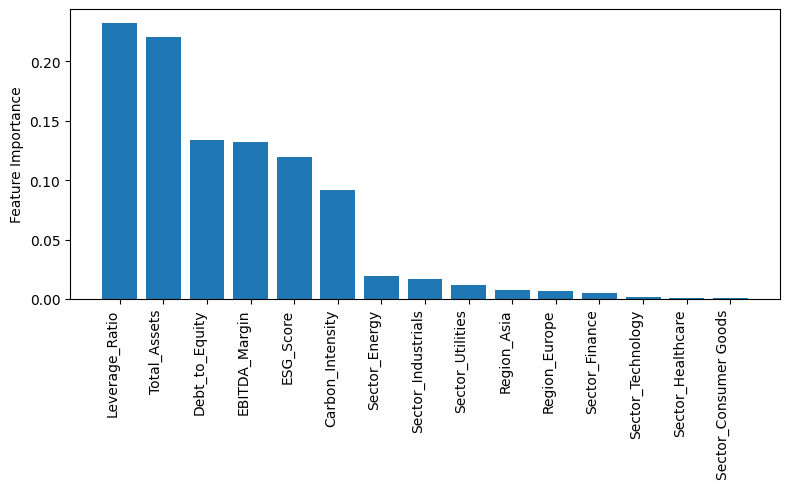

In [19]:
# Compute feature importances in RF
importances = rand_search.best_estimator_.steps[1][1].feature_importances_
feature_names = companies_df_clean.drop(columns=['CDS_Spread_5Y'])
feature_names = pd.get_dummies(feature_names, columns=['Sector', 'Region']).columns.tolist()
indices = importances.argsort()[::-1]

# Plot
plt.figure(figsize=(8,5))
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90, ha="right")
plt.ylabel("Feature Importance")
plt.tight_layout()
plt.show()

## Random Forest with sequential selection

In [20]:
X = companies_df_clean.drop(columns=['CDS_Spread_5Y'])
X = pd.get_dummies(X, columns=['Sector', 'Region'], drop_first=True)
y = companies_df_clean['CDS_Spread_5Y'].values
estimator = make_pipeline(StandardScaler(), RandomForestRegressor())
cv = LeaveOneOut()

# Forward stepwise selection
sfs_forward = SFS(
    estimator,
    k_features="best",
    forward=True,
    floating=False,
    scoring='neg_mean_squared_error',
    cv=5,
)
sfs_forward = sfs_forward.fit(X, y)
print("Forward-selected features:")
for feature in sfs_forward.k_feature_names_:
    print(f"  {feature}")


# Backward stepwise selection
sfs_backward = SFS(
    estimator,
    k_features="best",
    forward=False,
    floating=False,
    scoring='neg_mean_squared_error',
    cv=5,
)
sfs_backward = sfs_backward.fit(X, y)

print("Backward-selected features:")
for feature in sfs_backward.k_feature_names_:
    print(f"  {feature}")


Forward-selected features:
  EBITDA_Margin
  Leverage_Ratio
  Sector_Energy
  Sector_Finance
  Sector_Healthcare
  Sector_Industrials
Backward-selected features:
  EBITDA_Margin
  Leverage_Ratio
  Sector_Energy


Forward Stepwise Selection with RF:
Train RMSE: 6.44, R²: 0.88
CV RMSE: 18.03


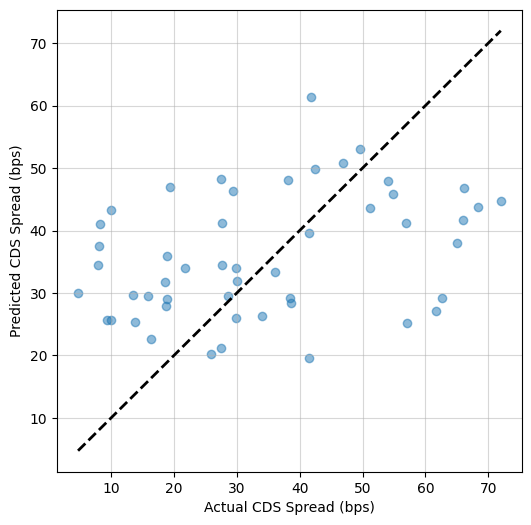

Backward Stepwise Selection with RF:
Train RMSE: 6.27, R²: 0.89
CV RMSE: 17.10


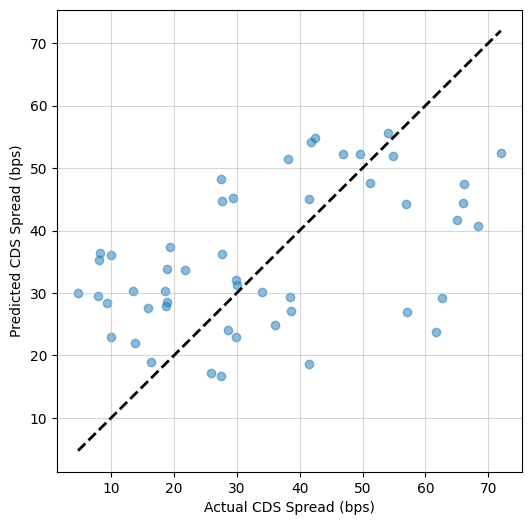

In [21]:
# Final evaluation of stepwise selected features with RF
X = companies_df_clean.drop(columns=['CDS_Spread_5Y'])
X = pd.get_dummies(X, columns=['Sector', 'Region'], drop_first=True)
X_forward = X[list(sfs_forward.k_feature_names_)]
X_backward = X[list(sfs_backward.k_feature_names_)]
y = companies_df_clean['CDS_Spread_5Y'].values
cv = LeaveOneOut()

ols_forward = make_pipeline(StandardScaler(), RandomForestRegressor())
print('Forward Stepwise Selection with RF:')
ols_results_forward = evaluate_model(ols_forward, X_forward, y, cv=cv)

ols_backward = make_pipeline(StandardScaler(), RandomForestRegressor())
print('Backward Stepwise Selection with RF:')
ols_results_backward = evaluate_model(ols_backward, X_backward, y, cv=cv)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Forward Selection - Best parameters found:
  randomforestregressor__max_depth: 10
  randomforestregressor__min_samples_leaf: 2
  randomforestregressor__min_samples_split: 4
  randomforestregressor__n_estimators: 314
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Backward Selection - Best parameters found:
  randomforestregressor__max_depth: 10
  randomforestregressor__min_samples_leaf: 2
  randomforestregressor__min_samples_split: 4
  randomforestregressor__n_estimators: 314

Forward Selection Model:
Train RMSE: 9.09, R²: 0.77
CV RMSE: 17.48


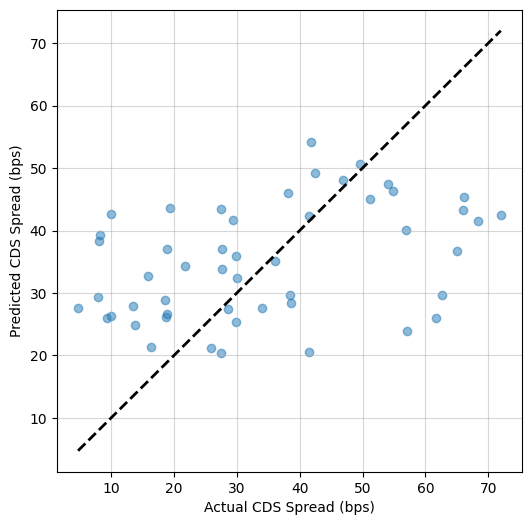


Backward Selection Model:
Train RMSE: 8.86, R²: 0.78
CV RMSE: 16.76


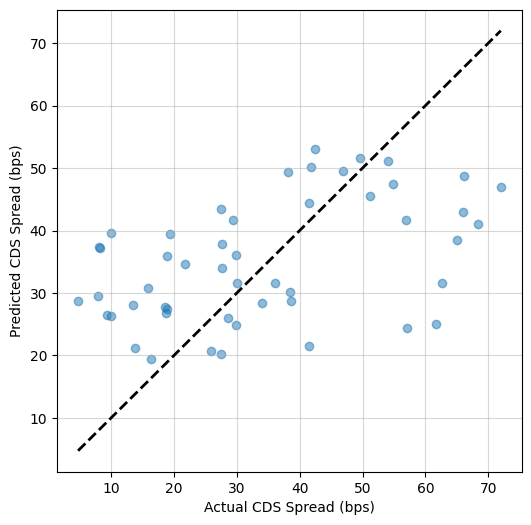

In [22]:
# Hyperparameter tuning for RF with stepwise selected features
X = companies_df_clean.drop(columns=['CDS_Spread_5Y'])
X = pd.get_dummies(X, columns=['Sector', 'Region'], drop_first=True)
X_forward = X[list(sfs_forward.k_feature_names_)]
X_backward = X[list(sfs_backward.k_feature_names_)]
y = companies_df_clean['CDS_Spread_5Y'].values
cv = 5

# Random Forest with forward selected features
rf_forward = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=SEED))

param_dist = {
    'randomforestregressor__n_estimators': randint(100, 500),
    'randomforestregressor__max_depth': [None, 5, 10, 20],
    'randomforestregressor__min_samples_split': randint(2, 10),
    'randomforestregressor__min_samples_leaf': randint(1, 5)
}

rand_search_forward = RandomizedSearchCV(
    rf_forward,
    param_distributions=param_dist,
    n_iter=20,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=SEED,
    verbose=1
)

rand_search_forward.fit(X_forward, y)

print("Forward Selection - Best parameters found:")
for param, value in rand_search_forward.best_params_.items():
    print(f"  {param}: {value}")

# Random Forest with backward selected features
rf_backward = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=SEED))

rand_search_backward = RandomizedSearchCV(
    rf_backward,
    param_distributions=param_dist,
    n_iter=20,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=SEED,
    verbose=1
)

rand_search_backward.fit(X_backward, y)

print("Backward Selection - Best parameters found:")
for param, value in rand_search_backward.best_params_.items():
    print(f"  {param}: {value}")

# Evaluate the best models
print("\nForward Selection Model:")
evaluate_model(rand_search_forward.best_estimator_, X_forward, y, cv=LeaveOneOut())

print("\nBackward Selection Model:")
evaluate_model(rand_search_backward.best_estimator_, X_backward, y, cv=LeaveOneOut())

In [23]:
from src.config import MODEL_DIR

joblib.dump({
    "model": rand_search_backward.best_estimator_,
    "features": list(X_backward.columns)
}, MODEL_DIR / "best_model.pkl")


['C:\\Users\\Jacopo\\Desktop\\Eco-Risk-Alpha\\models\\best_model.pkl']

# **CVA Computation**

## Utilities

In [3]:
from src.utils import compute_cva

## Interpolate Zero Rates

In [4]:
# Convert zero rates to float
maturities = zeros_df['Maturity'].values
zero_rates = zeros_df['Zero_Rate'].str.rstrip('%').astype(float) / 100

# Interpolate at x.5 years
additional_maturities = np.arange(1.5, 5.5, 1) # Changed upper bound to include 5.0
interpolated_zero_rates = np.interp(additional_maturities, maturities, zero_rates)

# Combine original and interpolated rates
all_maturities = np.concatenate([maturities, additional_maturities])
all_zero_rates = np.concatenate([zero_rates, interpolated_zero_rates])

# Sort by maturity
sort_indices = np.argsort(all_maturities)
all_maturities_sorted = all_maturities[sort_indices]
all_zero_rates_sorted = all_zero_rates[sort_indices]

# Create a new DataFrame with the combined rates
zeros_df_clean = pd.DataFrame({
    'Maturity': all_maturities_sorted,
    'Zero_Rate': all_zero_rates_sorted
})

print("\nInterpolated Zero Rates:")
display(zeros_df_clean)

maturities = zeros_df_clean['Maturity'].values
zero_rates = zeros_df_clean['Zero_Rate'].values


Interpolated Zero Rates:


,Maturity,Zero_Rate
0,0.5,0.02000
1,1.0,0.02050
2,1.5,0.02075
3,2.0,0.02100
4,2.5,0.02125
5,3.0,0.02150
6,3.5,0.02175
7,4.0,0.02200
8,4.5,0.02225
9,5.0,0.02250


## Compute CVA

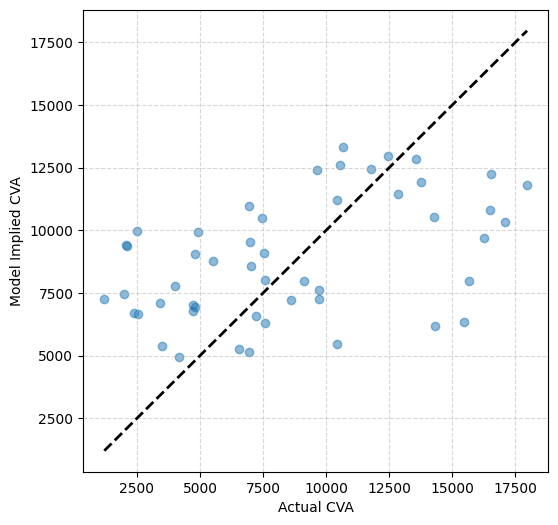

In [5]:
# Common parameters
maturities = zeros_df_clean['Maturity']
zero_rates = zeros_df_clean['Zero_Rate']
discount_factors = np.exp(-zero_rates * maturities)
expected_exposure = ee_df['EE']

# Load cleaned companies data
companies_df_clean = pd.read_csv(DATA_DIR / "cleaned_companies_data.csv")

# Load best model
from src.config import MODEL_DIR
best_model = joblib.load(MODEL_DIR / "best_model.pkl")

# Features and target
X = companies_df_clean.drop(columns=['CDS_Spread_5Y'])
X = pd.get_dummies(X, columns=['Sector', 'Region'], drop_first=True)
X = X[best_model['features']]
y = companies_df_clean['CDS_Spread_5Y']
cv = LeaveOneOut()
model = best_model['model']

# Actual CVA
CDS_actual = companies_df_clean['CDS_Spread_5Y']
CVA_actual = compute_cva(CDS_actual, discount_factors, expected_exposure, maturities, LGD)

# Model implied CVA
CDS_model = cross_val_predict(model, X, y, cv=cv)
CVA_model = compute_cva(CDS_model, discount_factors, expected_exposure, maturities, LGD)

# Plot CVAs
plt.figure(figsize=(6,6))
plt.scatter(CVA_actual, CVA_model, alpha=0.5)
plt.plot([min(CVA_actual), max(CVA_actual)], [min(CVA_actual), max(CVA_actual)], 'k--', lw=2)
plt.xlabel("Actual CVA")
plt.ylabel("Model Implied CVA")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

## Compute Green Premimum

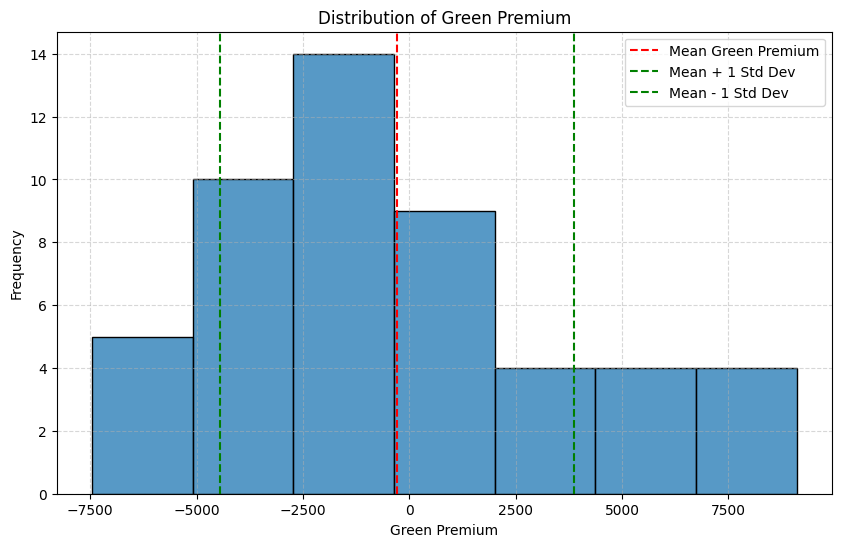

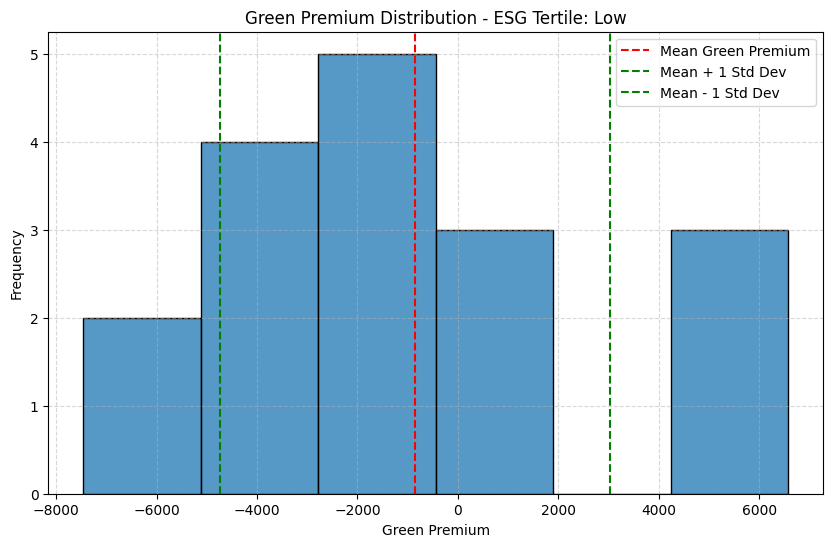

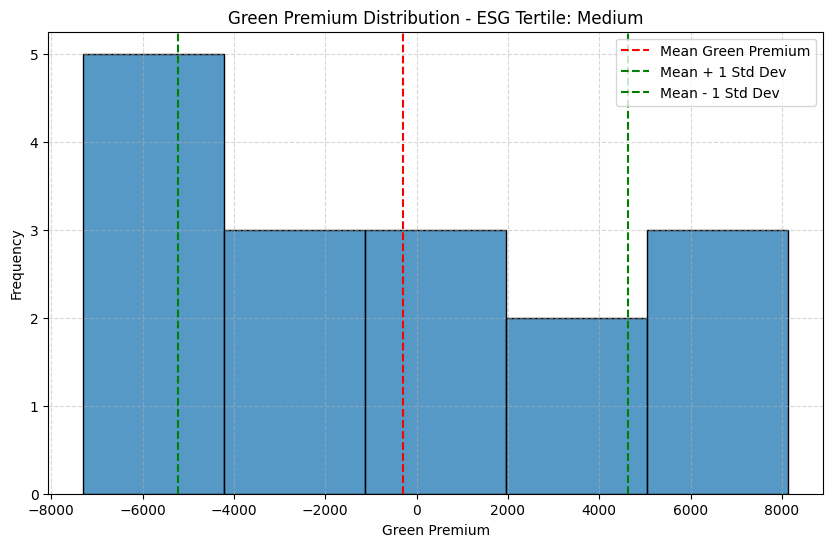

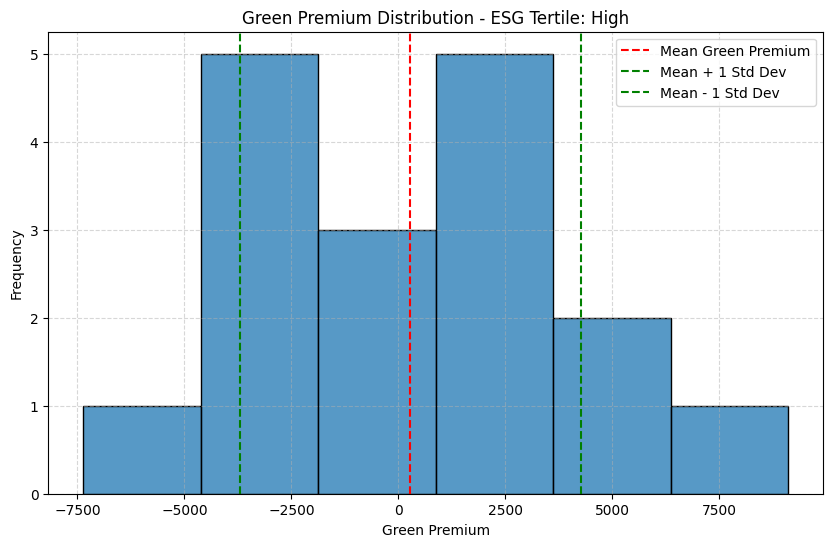

In [6]:
# Compute green premimum
green_prem = CVA_actual - CVA_model
plt.figure(figsize=(10, 6))
sns.histplot(green_prem, kde=False)
plt.axvline(green_prem.mean(), color='r', linestyle='--', label='Mean Green Premium') #
plt.axvline(green_prem.mean() + green_prem.std(), color='g', linestyle='--', label='Mean + 1 Std Dev')
plt.axvline(green_prem.mean() - green_prem.std(), color='g', linestyle='--', label='Mean - 1 Std Dev')
plt.xlabel('Green Premium')
plt.ylabel('Frequency')
plt.title('Distribution of Green Premium')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# ESG tertile bucket
companies_df_clean['Green_Premium'] = green_prem
companies_df_clean['ESG_tertile'] = pd.qcut(companies_df_clean['ESG_Score'], 3, labels=['Low', 'Medium', 'High'])

# Calculate mean green premium by ESG tertile
mean_green_premium_by_tertile = companies_df_clean.groupby('ESG_tertile', observed=False)['Green_Premium'].mean()

# Plot green premimum distribution by ESG tertile
for tertile, group in companies_df_clean.groupby('ESG_tertile', observed=False):
    plt.figure(figsize=(10, 6))
    sns.histplot(group['Green_Premium'], kde=False)
    plt.axvline(group['Green_Premium'].mean(), color='r', linestyle='--', label='Mean Green Premium')
    plt.axvline(group['Green_Premium'].mean() + group['Green_Premium'].std(), color='g', linestyle='--', label='Mean + 1 Std Dev')
    plt.axvline(group['Green_Premium'].mean() - group['Green_Premium'].std(), color='g', linestyle='--', label='Mean - 1 Std Dev')
    plt.xlabel('Green Premium')
    plt.ylabel('Frequency')
    plt.title(f'Green Premium Distribution - ESG Tertile: {tertile}')
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# **Table of Results**


In [35]:
table = pd.DataFrame({
    "CDS_actual": CDS_actual,
    "CVA_actual": CVA_actual,
    "CDS_model":  CDS_model,
    "CVA_model":  CVA_model,
})
display(table)


,CDS_actual,CVA_actual,CDS_model,CVA_model
0,34.0068,8589.712771,26.591132,6732.769675
1,38.1718,9628.744635,45.821720,11529.843525
2,61.7321,15453.667559,25.102964,6359.040754
3,29.9490,7574.715896,31.181992,7883.413108
4,27.6713,7003.809804,34.262437,8653.566847
5,65.1008,16279.276590,43.709926,11005.980065
6,18.5712,4714.411195,35.057641,8852.128596
7,27.4909,6958.556359,16.888259,4289.530840
8,8.1874,2085.448518,37.940619,9571.146185
9,29.8871,7559.211816,21.456665,5441.802611
